In [1]:
import datetime as dt
import os
import sys
sys.path.append(os.pardir)

import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import pandas as pd

from covid_19.growth_models import GrowthCOVIDModel

In [2]:
def plot_dataframe(df):
    """
    Plot epi data over time.
    
    Parameters
    ----------
    df : pandas.Dataframe
        Epidemiological data in DataFrame format with 4 features:
        date, confirmed_cases, recovered_cases, death_cases
    """
    fig = plt.figure(figsize=(12, 8))
    axs = fig.subplots(nrows=4, ncols=1, sharex=True, squeeze=True)
    axs[0].plot(
        df.date, df.confirmed_cases, 
        color='blue', linestyle='-', marker='None', 
        label='Confirmed cases',
    )
    axs[0].plot(
        df.date, df.recovered_cases, 
        color='red', linestyle='-', marker='None', 
        label='Recovered cases',
    )
    axs[0].legend()
    axs[0].grid()
    axs[1].plot(
        df.date, 
        df.confirmed_cases - df.recovered_cases, 
        color='blue', linestyle='-', marker='None', 
        label='Active cases',
    )
    axs[1].legend()
    axs[1].grid()
    axs[2].plot(
        df.date, df.death_cases, 
        color='blue', linestyle='-', marker='None', 
        label='Deceased cases',
    )
    axs[2].legend()
    axs[2].grid()
    axs[3].plot(
        df.date, df.daily_tests, 
        color='blue', linestyle='-', marker='None', 
        label='Daily tests',
    )
    axs[3].legend()
    axs[3].grid()
    plt.show()

        date  confirmed_cases  recovered_cases  death_cases  daily_tests
0 2020-02-26              1.0              0.0          0.0          8.0
1 2020-02-27              3.0              0.0          0.0          8.0
2 2020-02-28              3.0              0.0          0.0          8.0
3 2020-02-29              5.0              0.0          0.0          8.0
4 2020-03-01              6.0              0.0          0.0          8.0 
(...)
           date  confirmed_cases  recovered_cases  death_cases  daily_tests
187 2020-08-31          10123.0           7212.0        184.0        922.0
188 2020-09-01          10269.0           7434.0        186.0       1591.0
189 2020-09-02          10414.0           7735.0        187.0       2995.0
190 2020-09-03          10725.0           7968.0        191.0       4122.0
191 2020-09-04          11094.0           8266.0        194.0       4492.0


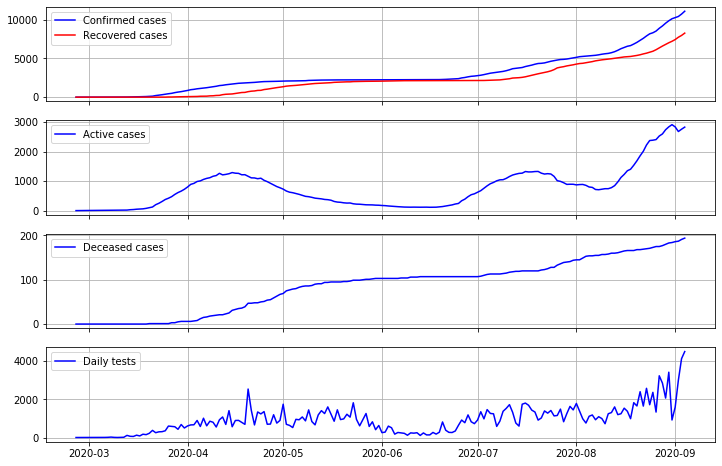

In [3]:
# data
confirmed_cases = np.loadtxt('../data/confirmed_cases.dat')
recovered_cases = np.loadtxt('../data/recovered_cases.dat')
death_cases = np.loadtxt('../data/death_cases.dat')
tests = np.loadtxt('../data/tests.dat')

epidemics_start_date = dt.datetime(2020, 2, 26)
date_list = [
    epidemics_start_date + dt.timedelta(days=i) 
    for i in range(confirmed_cases.size)
]

# full data dataframe
df = pd.DataFrame({
    'date': date_list,
    'confirmed_cases': confirmed_cases,
    'recovered_cases': recovered_cases,
    'death_cases': death_cases,
    'daily_tests': tests,
})
print(df.head(), '\n(...)\n', df.tail())

# visualization of full data
plot_dataframe(df)

        date  confirmed_cases  recovered_cases  death_cases  daily_tests
0 2020-06-02           2246.0           2077.0        103.0        290.0
1 2020-06-03           2246.0           2088.0        103.0        602.0
2 2020-06-04           2246.0           2095.0        103.0        517.0
3 2020-06-05           2247.0           2105.0        103.0        183.0
4 2020-06-06           2247.0           2113.0        103.0        270.0 
(...)
           date  confirmed_cases  recovered_cases  death_cases  daily_tests
187 2020-08-31          10123.0           7212.0        184.0        922.0
188 2020-09-01          10269.0           7434.0        186.0       1591.0
189 2020-09-02          10414.0           7735.0        187.0       2995.0
190 2020-09-03          10725.0           7968.0        191.0       4122.0
191 2020-09-04          11094.0           8266.0        194.0       4492.0


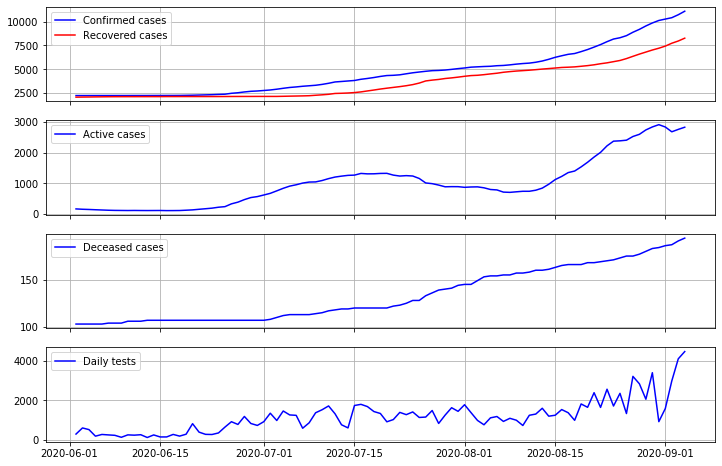

In [4]:
# second wave data dataframe
df_2 = df[df.date>dt.datetime(2020, 6, 1)]
df_2 = df_2.reset_index(drop=True)
print(df_2.head(), '\n(...)\n', df.tail())

# visualization
plot_dataframe(df_2)

In [5]:
def simulate(
    function, 
    eff_date, 
    confirmed_cases, 
    normalize_data, 
    n_days, 
    plot_confidence_intervals=False, 
    **kwargs
):
    """
    Fit the data to exponential function and plot n_days forecast.
        
    Parameters
    ----------
    function : str
        Growth curve.
    eff_date : datetime.datetime
        Start date of simulation.
    confirmed_cases : numpy.ndarray
        Number of confirmed infected COVID-19 cases per day since 
        `eff_date`.
    n_days : int
        Number of days to extrapolate.
    plot_confidence_intervals : bool, optional
        Plot confidence intervals.
    kwargs
        If specified, keyword arguments are passed to 
        `GrowthCOVIDModel` when `confidence_interval`=True.
    """
    confirmed_cases_adjusted = confirmed_cases
    exp_model = GrowthCOVIDModel(
        function=function,
        normalize=normalize_data,
        confidence_interval=plot_confidence_intervals,
        **kwargs
    )
    x, fitted_curve = exp_model.fit(confirmed_cases)
    date_list = [
        eff_date + dt.timedelta(days=i) for i in range(x.size)
    ]
    x_future, predicted_curve = exp_model.predict(n_days)
    date_list_future = [
        date_list[-1] + dt.timedelta(days=i) 
        for i in range(x_future.size)
    ]
    props = dict(boxstyle='round', facecolor='lavender', alpha=1.0)
      
    plt.figure(figsize=(12, 8))
    plt.plot(
        date_list,
        confirmed_cases_adjusted,
        color='blue', linestyle='-', marker='o', markersize=9, 
        label='confirmed cases',
    )
    if plot_confidence_intervals:
        plt.plot(
            date_list, 
            fitted_curve[0, :], 
            color='red', linestyle='--', marker='None', 
            label=f'lower/upper bound',
        )
        plt.plot(
            date_list, 
            fitted_curve[1, :],
            color='red', linestyle='-', marker='None', 
            label=f'{function} fit',
        )
        plt.plot(
            date_list,
            fitted_curve[2, :],
            color='red', linestyle='--', marker='None',
        )
        plt.fill_between(
            date_list,
            fitted_curve[0, :],
            fitted_curve[2, :], 
            color='red', alpha=0.1,
        )
        
        plt.plot(
            date_list_future,
            predicted_curve[0, :],
            color='red', linestyle='--', marker='None',
        )
        plt.plot(
            date_list_future,
            predicted_curve[1, :],
            color='red', linestyle='-', marker='o',  
            label='extrapolated curve',
        )
        plt.plot(
            date_list_future,
            predicted_curve[2, :],
            color='red', linestyle='--', marker='None',
        )
        plt.fill_between(
            date_list_future,
            predicted_curve[0, :],
            predicted_curve[2, :],
            color='red', alpha=0.1,
        )
        
        for idx, vals in enumerate(zip(
                date_list_future[1:], 
                predicted_curve[1,1:])):
            plt.text(
                vals[0], vals[1] - 175, 
                str(int(vals[1])), 
                verticalalignment='top', bbox=props,
            )
    else:
        plt.plot(
            date_list,
            fitted_curve,
            color='red', linestyle='-', marker='None', 
            label=f'{function} fit',
        )
        plt.plot(
            date_list_future,
            predicted_curve,
            color='red', linestyle='--', marker='o',  
            label='extrapolated curve',
        )
        for idx, vals in enumerate(zip(
            date_list_future[1:], predicted_curve[1:])):
            plt.text(
                vals[0], vals[1] - 175, 
                str(int(vals[1])), 
                verticalalignment='top', bbox=props,
            )
    plt.legend()
    plt.grid()
    plt.gcf().autofmt_xdate()
    plt.show()

In [6]:
eff_date = dt.datetime(2020, 8, 1)
confirmed_cases = df_2[df_2.date > eff_date].confirmed_cases.values
daily_tests = df_2[df_2.date > eff_date].daily_tests.values
n_days = 7

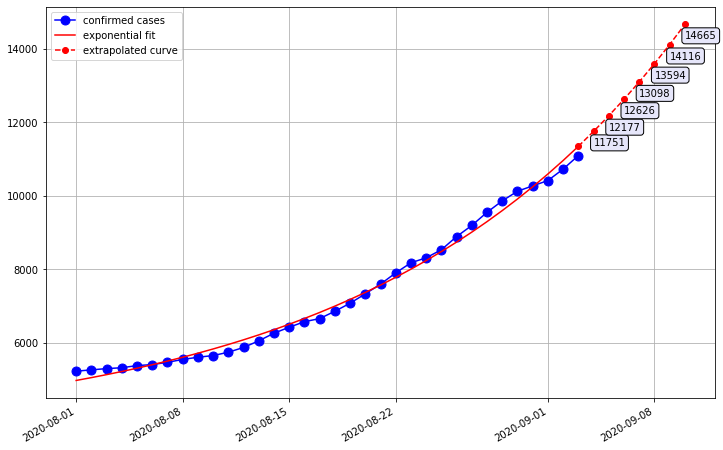

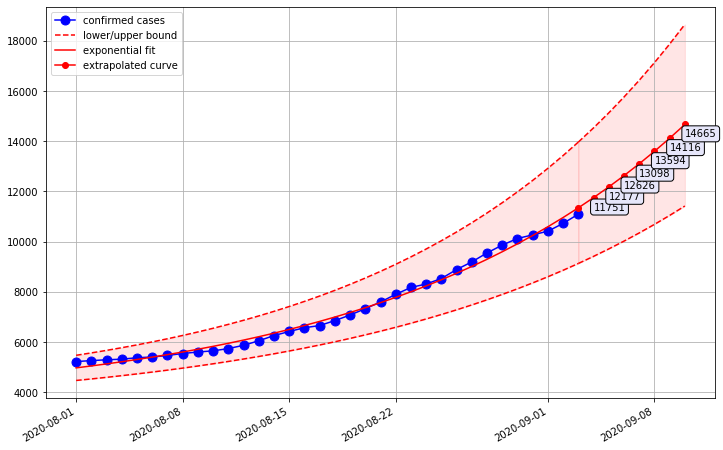

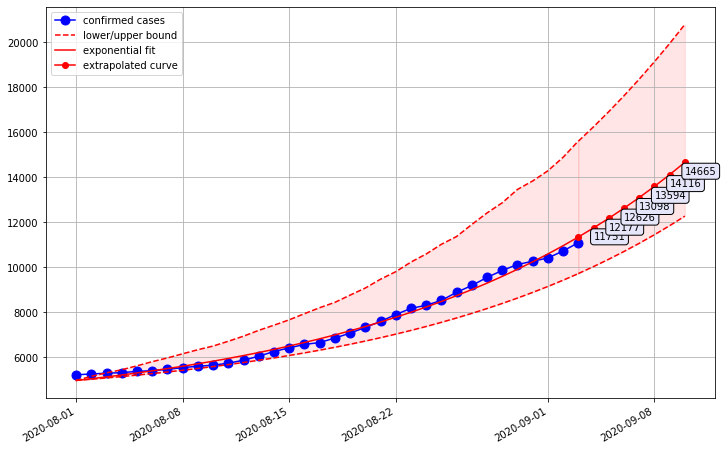

In [7]:
simulate(
    function='exponential', 
    eff_date=eff_date, 
    confirmed_cases=confirmed_cases, 
    normalize_data=True,
    n_days=n_days,
)

simulate(
    function='exponential', 
    eff_date=eff_date, 
    confirmed_cases=confirmed_cases, 
    normalize_data=True,
    n_days=n_days, 
    plot_confidence_intervals=True,
)

simulate(
    function='exponential', 
    eff_date=eff_date, 
    confirmed_cases=confirmed_cases, 
    normalize_data=True,
    n_days=n_days, 
    plot_confidence_intervals=True, 
    sensitivity=0.8, 
    specificity=0.9, 
    ci_level=95, 
    daily_tests=daily_tests,
)

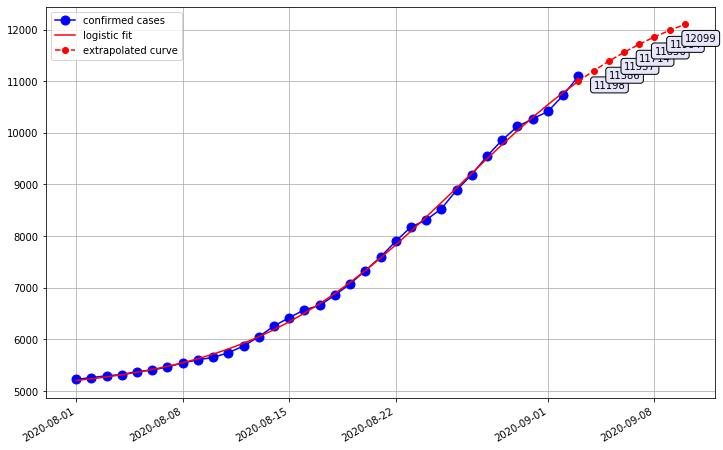

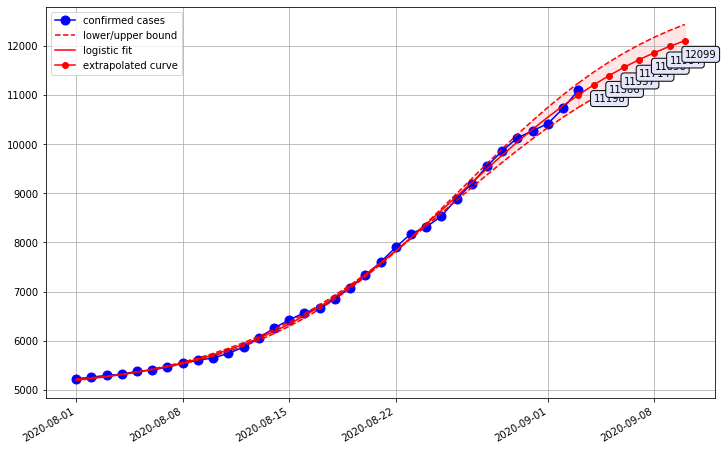

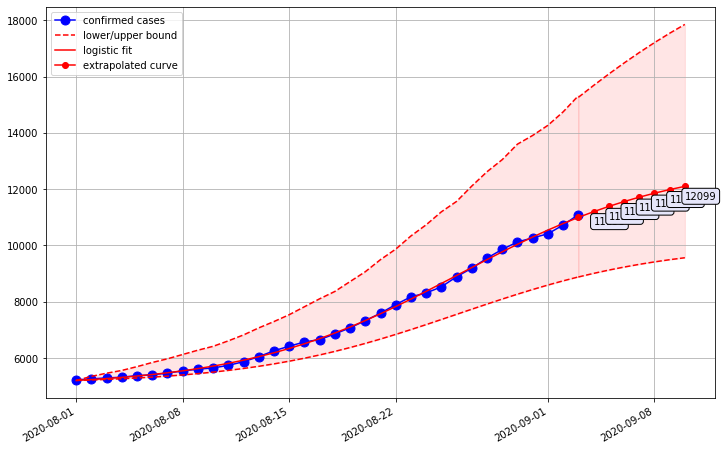

In [8]:
simulate(
    function='logistic', 
    eff_date=eff_date, 
    confirmed_cases=confirmed_cases, 
    normalize_data=True,
    n_days=n_days,
)

simulate(
    function='logistic', 
    eff_date=eff_date, 
    confirmed_cases=confirmed_cases,
    normalize_data=True,
    n_days=n_days, 
    plot_confidence_intervals=True,
)

simulate(
    function='logistic', 
    eff_date=eff_date, 
    confirmed_cases=confirmed_cases, 
    normalize_data=True,
    n_days=n_days, 
    plot_confidence_intervals=True,
    sensitivity=0.7, 
    specificity=0.9,
    ci_level=95,
    daily_tests=daily_tests,
)